# Range-Doppler Image Classification Using Convolutional Neural Network and Pre-trained Networks Trained to ImageNet Dataset 
## Nome: Rodrigo de Lima Florindo
## Matrícula: 101809

Notes:
- For properly running this project, you need to manually download this dataset: "https://www.kaggle.com/datasets/iroldan/real-doppler-raddar-database/discussion/568518", unzip it in a folder named "dataset" inside Projeto 4 folder, and manually delete the "data" folder that is inside the unzipped folder. For some reasone, "data" is just a duplicate that is there for now reason.

### Transforming the .csv datasets into Numpy arrays

In [ ]:
import kagglehub
from pathlib import Path
import numpy as np # linear algebra
import matplotlib.pyplot as plt # graph plotting
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

root = Path("dataset")

CLASS = {'Cars':0, 'Drones': 1, 'People':2}

# find all CSVs whose parent-dir is a known class
files = [p for p in root.rglob("*.csv") if p.parent.parent.name in CLASS]

# read
imgs  = [pd.read_csv(p, header=None).to_numpy() for p in files]
labels = np.fromiter((CLASS[p.parent.parent.name] for p in files), dtype=np.int64)
paths  = np.array([str(p.relative_to(root)) for p in files])

# if all images are same shape, stack to one array (faster & smaller)
x = np.stack(imgs).astype(np.float32)   # (N, H, W)
y = labels
d = paths

print(len(files), "files loaded.")

17485 files loaded.


### Visualization of some dataset images
First, we show examples of a car, a person and a drone:

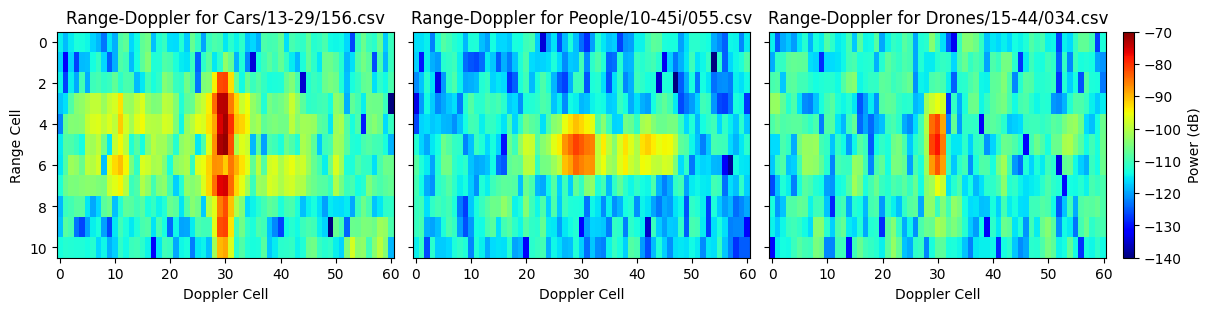

In [70]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

idxs = [100, 6100, 14100]
labels = ["Cars", "People", "Drones"]

vmin, vmax = -140, -70
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True, sharey=True)

for ax, i in zip(axes, idxs):
    im = ax.imshow(x[i], cmap='jet', norm=norm)
    ax.set_aspect('auto')              # <-- allow non-square pixels
    ax.set_title(f'Range-Doppler for {paths[i]}')
    ax.set_xlabel('Doppler Cell')
axes[0].set_ylabel('Range Cell')

sm = ScalarMappable(norm=norm, cmap='jet'); sm.set_array([])
fig.colorbar(sm, ax=axes, location='right', fraction=0.046, pad=0.01, label='Power (dB)')

plt.show()


In sequence, we show also some plots of the same target, but for different time instants.

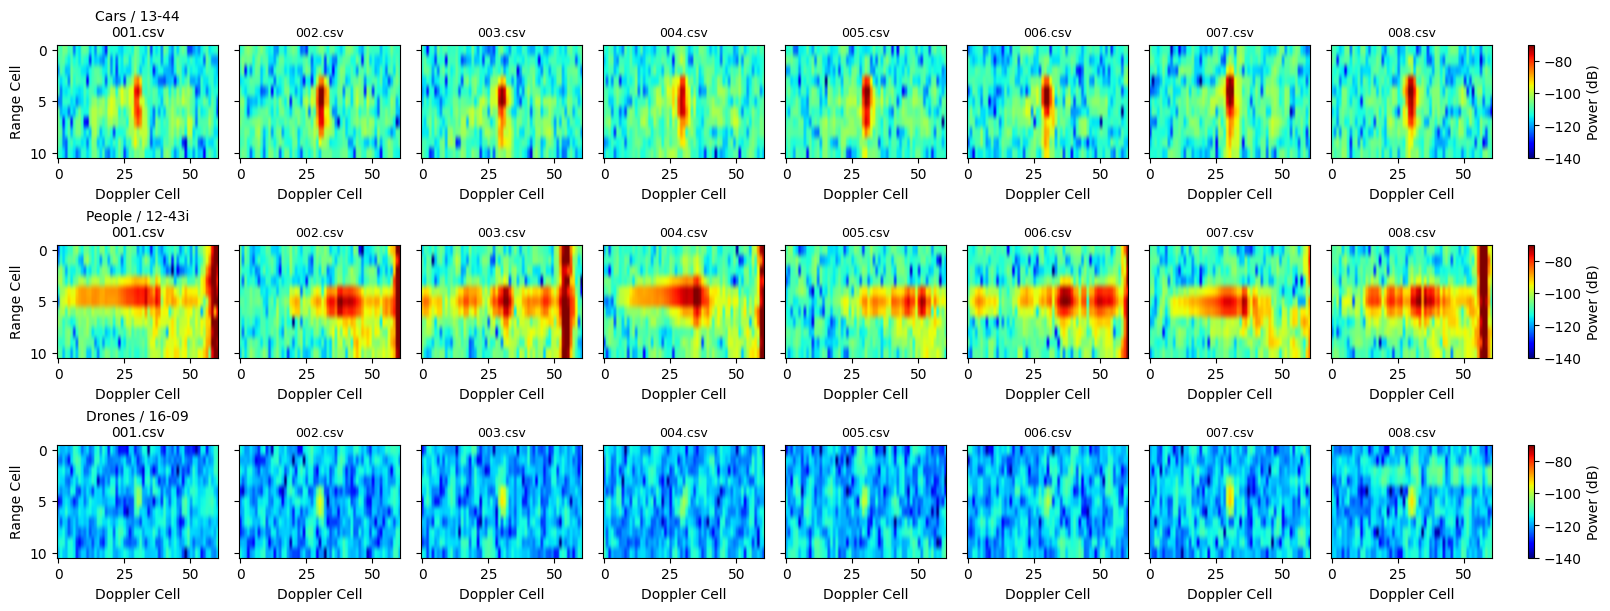

In [89]:
# === 3×8: first object per class; columns = time/order of its CSVs ===
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# --- Pick object subfolder for each class (EDIT THESE NAMES) ---
choices = {
    "Cars":   "13-44",   # <- put the object folder you want for Cars
    "People": "12-43i",  # <- for People
    "Drones": "16-09",   # <- for Drones
}

rows = []
for cls in ["Cars", "People", "Drones"]:
    obj = choices.get(cls)

    # indices whose path starts with "Class/Object/"
    idxs = [i for i, p in enumerate(d) if p.startswith(f"{cls}/{obj}/")]

    # sort by filename (001.csv, 002.csv, ...) and take first 8
    idxs = sorted(idxs, key=lambda i: Path(d[i]).name)[:8]

    rows.append((cls, obj or "<none>", idxs))

vmin, vmax = -140, -70
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(3, 8, figsize=(16, 6), constrained_layout=True, sharey=True)

for r, (cls, obj, idxs) in enumerate(rows):   # <-- uses rows built in the previous cell
    row_axes = axes[r]

    for c in range(8):
        ax = row_axes[c]
        if c < len(idxs):
            i = idxs[c]
            im = ax.imshow(x[i], cmap='jet', norm=norm, aspect='auto')  # no smoothing
            fname = Path(d[i]).name
            # first column: show class/object + filename (e.g., 001.csv)
            if c == 0:
                ax.set_title(f"{cls} / {obj}\n{fname}", fontsize=10)
            else:
                ax.set_title(fname, fontsize=9)
            ax.set_xlabel('Doppler Cell')
        else:
            ax.axis('off')

    row_axes[0].set_ylabel('Range Cell')

    # one colorbar **per row**
    sm = ScalarMappable(norm=norm, cmap='jet'); sm.set_array([])
    fig.colorbar(sm, ax=row_axes, location='right', fraction=0.046, pad=0.02, label='Power (dB)')

plt.show()



### Prepare Training, Validation, and Test Datasets, as suggested by the article